# Fermi limits with Sommerfeld enhancement

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import scipy.integrate as integrate
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

At freeze-out, we want
$$
\langle \sigma v \rangle _{relic} = \frac{\pi \alpha^2}{M_{DM}^2} S_{FO} = \frac{\pi \alpha^2}{M_{DM}^2} 2\pi \frac{\alpha}{v_{rel}} \frac{1}{1- e^{-2\pi \alpha / v_{rel}}}
$$
where $\langle 1/ v_{rel} \rangle=4$ at freeze-out. At these velocities, there's basically no difference between the thermally averaged Sommerfeld enhancement factor and the Sommerfeld enhancement factor calculated at $v = \langle v_{rel} \rangle$. We also know that $\langle \sigma v \rangle _{relic} = 4.4\times 10^{-26} \mathrm{cm}^3 \mathrm{s}^{-1}$ for our model with non-self-conjugate DM. In reference [13], which is the paper about Fermi limits, they use self-conjugate DM, therefore we will have to weaken the limits by a factor of 2. We want to use the equation above to derive $\alpha(M)$ that reproduces the correct relic abundance, but the equation does not have an analytic solution. Below I solve it numerically.

In [53]:
sigmav_conversion = 1.52 * 10 ** 24 / (5.06 * 10 ** 13) ** 3 # Converts from GeV^-2 to cm^3s^-1
sigmav_relic = 4.4 * 10**(-26) # cm^-3s^-1
sigmav_relic_GeV = sigmav_relic / sigmav_conversion # GeV^-2

avg_vrel_FO = 1 / 4 # in units of c

def MB(vrel, vdisp):
	return 1 / np.sqrt(4 * np.pi) * vrel**2 / vdisp**3 * np.exp(-vrel**2 / (4 * vdisp**2))

def S(alpha, vrel):
	coefficient = 2 * np.pi * alpha / vrel
	return coefficient / (1 - np.exp(-coefficient))

# alpha with Sommerfeld enhancement
def alpha_single(M):
	equation_to_solve = lambda alpha : sigmav_relic_GeV - np.pi * alpha ** 2 / M ** 2 * S(alpha, avg_vrel_FO)
	return opt.fsolve(equation_to_solve, 0.1)[0]

alpha = np.vectorize(alpha_single)

# alpha without Sommerfeld enhancement
def simple_alpha(M):
	return M * np.sqrt(sigmav_relic_GeV / np.pi)

Below I'm plotting the dependence of $\alpha$ on $M_{DM}$ with this new equation, and I'm comparing it to the one I found in excercise 3.3 which was just a linear dependence.

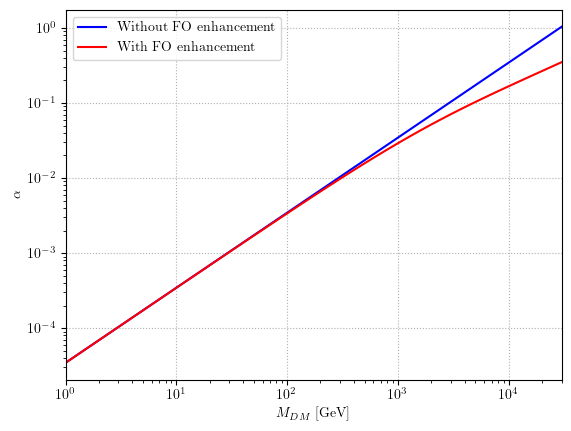

In [54]:
plt.xlabel("$M_{DM}$ [GeV]")
plt.ylabel("$\\alpha$")
plt.xscale("log")
plt.yscale("log")
plt.grid(linestyle=':')
plt.margins(x=0)
M_axis = np.logspace(0, np.log10(30000))
plt.plot(M_axis, M_axis * np.sqrt(sigmav_relic_GeV / np.pi), color="blue", label="Without FO enhancement");
plt.plot(M_axis, alpha(M_axis), color="red", label="With FO enhancement");
plt.legend();
plt.savefig("alpha.pdf")

From the literature, I gathered that $\sigma \simeq 10 \mathrm{km}/\mathrm{s}$ is the velocity dispersion in dwarf spheroidal galaxies, which are the object of study of the Fermi collaboration. 

In [55]:
vdisp_dSph = 10 / 300000 # 10 km/s in units of c
avg_vrel_dSph = 4 * vdisp_dSph / np.sqrt(np.pi) # in units of c

def avgS_single(alpha):
	integrand = lambda vrel : MB(vrel, vdisp_dSph) * S(alpha, vrel)
	# Limit the integration to 4 times the average in order to prevent the integral from returning 0
	integral, _ = integrate.quad(integrand, 0, avg_vrel_dSph * 4)
	return integral

avgS = np.vectorize(avgS_single)

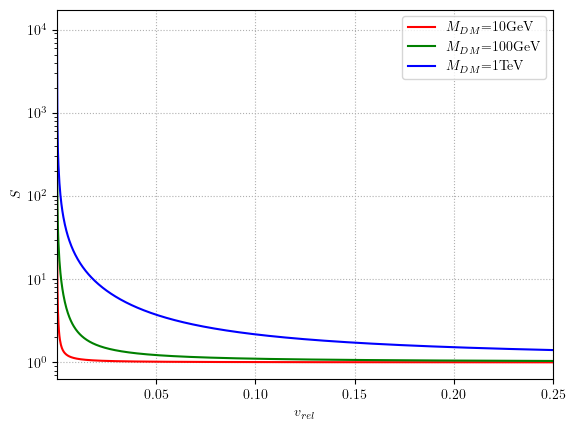

In [56]:
v_axis = np.linspace(5 / 300000, 0.25, 1000)

plt.xlabel("$v_{rel}$")
plt.ylabel("$S$")
plt.yscale("log")
plt.grid(linestyle=':')
plt.margins(x=0)
plt.plot(v_axis, S(alpha(10), v_axis), color="red", label="$M_{DM}$=10GeV");
plt.plot(v_axis, S(alpha(100), v_axis), color="green", label="$M_{DM}$=100GeV");
plt.plot(v_axis, S(alpha(1000), v_axis), color="blue", label="$M_{DM}$=1TeV");
plt.legend();
plt.savefig("enhancement_factor.pdf")

I now use the result from the previous equation to calculate the enhanced cross-section relevant for the Fermi limits today. The enhanced cross-section is
$$
\langle \sigma v \rangle _{dSph} = \frac{\pi \alpha^2}{M_{DM}^2} \langle S_{dSph} \rangle = \frac{\pi \alpha^2}{M_{DM}^2} \left\langle 2\pi \frac{\alpha}{v} \frac{1}{1- e^{-2\pi \alpha / v}} \right\rangle
$$

In [57]:
def sigmav_now(M):
	a = alpha(M)
	return sigmav_conversion * np.pi * a ** 2 / M ** 2 * avgS(a)

In [58]:
import csv

M = []
sigmav = []
with open('fermi-data.csv', 'r') as f:
	reader = csv.reader(f)
	next(reader)  # skip header

	for row in reader:
		if row:  # skip empty rows
			M.append(float(row[0]))
			sigmav.append(float(row[1]) * 10**(-26))

	M = np.array(M)
	sigmav = np.array(sigmav)

In [59]:
def fit_func(M, K, M0, a, b):
	return K * (M / M0) ** (-a - b * np.log(M / M0))

popt, pcov = opt.curve_fit(fit_func, M, sigmav * 2, p0=[10**(-26), 1, 1, -1])

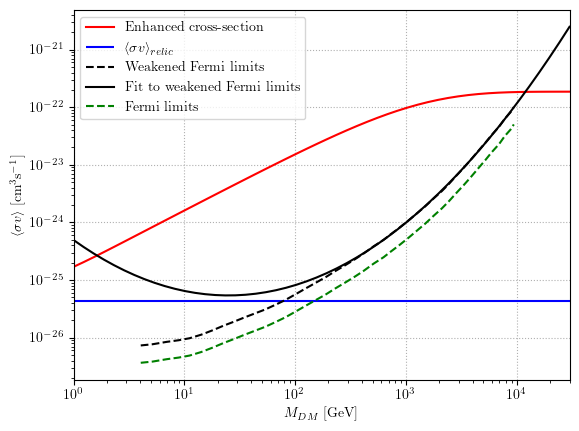

In [60]:
plt.xlabel("$M_{DM}$ [GeV]")
plt.ylabel("$\\langle \\sigma v \\rangle \\ [\\mathrm{cm}^3\\mathrm{s}^{-1}]$")
plt.xscale("log")
plt.yscale("log")
plt.margins(x=0)
plt.grid(linestyle=':')
plt.plot(M_axis, sigmav_now(M_axis), color="red", label="Enhanced cross-section");
plt.hlines(y=sigmav_relic, xmin=M_axis[0], xmax=M_axis[-1], color="blue", label="$\\langle \\sigma v \\rangle_{relic}$");
plt.plot(M, sigmav * 2, '--', color="black", label="Weakened Fermi limits");
plt.plot(M_axis, fit_func(M_axis, *popt), color="black", label="Fit to weakened Fermi limits");
plt.plot(M, sigmav, '--', color="green", label="Fermi limits");
plt.legend();
plt.savefig("comparison.pdf")

In [61]:
indices_above = np.where(sigmav * 2 > sigmav_relic)[0]
index = indices_above[0]

print(f"Without Sommerfeld enhancement, prediction and limits meet at M={M[index]:.2f}GeV")

Without Sommerfeld enhancement, prediction and limits meet at M=82.14GeV


In [62]:
sol = opt.fsolve(lambda x: fit_func(x, *popt) - sigmav_now(x), 10**4)[0]
print(f"With Sommerfeld enhancement, prediction and limits meet at M={sol / 1000:.2f}TeV.")

With Sommerfeld enhancement, prediction and limits meet at M=11.97TeV.


It appears to me that no constraint can be put on $M$, as the enhanced cross-section is always above the dSph $4\tau$ graph for the range taken into consideration ($1-10^4\mathrm{GeV}$). We can put a constraint if we extend the experimental data beyond $10^4\mathrm{GeV}$.

## Checking whether the Coulomb approximation was valid

I am now checking whether
$$
\frac{M_{DM} v_{rel}}{2m_V} \geq 1
$$

In [63]:
m_tau = 1.77682 # in GeV

ratio = sol * avg_vrel_dSph / 4 / m_tau

print(f"The ratio is {ratio:.2f}.")

if ratio < 1:
	print("The Coulomb approximation was not valid, we should have used Yukawa or Hulthen.")
else:
	print("The Coulomb approximation was valid, we can use it to calculate the cross-section.")

The ratio is 0.13.
The Coulomb approximation was not valid, we should have used Yukawa or Hulthen.


See page 5 of [14] for what it means to have a Yukawa potential. Basically, the Sommerfeld enhancement saturates at low velocities and this limits how big the enhancement can get. It likely means that the minimum $M_{DM}$ is a bit less than $10\mathrm{TeV}$.